In [1]:
%%html
<iframe style="aspect-ratio: 1200 / 630; width:100%; height:fit-content;" src="https://www.coindesk.com/embedded-chart/GRdgwdpLtpFTd" width="100%" frameborder="0" scrolling="no"></iframe>

# Import libraries

In [2]:
import tensorflow as tf
from tensorflow.keras import layers

import sys
import os
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.compose import make_reduction
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

In [3]:
sys.path.append(os.path.abspath(os.path.join('..', 'scripts')))

from utils import \
    get_binance_klines, \
    plot_time_series, \
    custom_plot_series, \
    evaluate_preds, \
    get_labelled_windows, \
    make_windows, \
    make_train_test_splits

# Get Data

In [4]:
symbol = 'BTCUSDT'
interval = '1d'
start_date = '2017-01-01'
end_date = datetime.now().strftime('%Y-%m-%d')

df = get_binance_klines(symbol, interval, start_date, end_date)

if df is not None:
    # Define the full path to the file in the data folder
    data_dir = '../data/'
    csv_file = os.path.join(data_dir, 'binance_btcusdt_price_history.csv')
    
    # Save the data to a CSV file in the data folder
    df.to_csv(csv_file, index=False)
    print(f"Historical Bitcoin price data from Binance downloaded and saved to '{csv_file}'")

    # Get the last element of the DataFrame
    last_element = df.iloc[-1]
    print("\nLast element of the DataFrame:")
    print(last_element)

Historical Bitcoin price data from Binance downloaded and saved to '../data/binance_btcusdt_price_history.csv'

Last element of the DataFrame:
open                                 61706.46000000
high                                 62225.31000000
low                                  60650.00000000
close                                60893.99000000
volume                               19869.34603000
close_time                            1719619199999
quote_asset_volume              1220658963.18923070
number_of_trades                            1101637
taker_buy_base_asset_volume          10250.07844000
taker_buy_quote_asset_volume     629766536.14422110
ignore                                            0
Name: 2024-06-28 00:00:00, dtype: object


The bitcoin historical data in [Binance](https://www.binance.com/en) starts in **2017-08-17**

In [5]:
df.head()

,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore
Date,,,,,,,,,,,
2017-08-17,4261.48000000,4485.39000000,4200.74000000,4285.08000000,795.15037700,1503014399999,3454770.05073206,3427,616.24854100,2678216.40060401,0
2017-08-18,4285.08000000,4371.52000000,3938.77000000,4108.37000000,1199.88826400,1503100799999,5086958.30617151,5233,972.86871000,4129123.31651808,0
2017-08-19,4108.37000000,4184.69000000,3850.00000000,4139.98000000,381.30976300,1503187199999,1549483.73542151,2153,274.33604200,1118001.87008735,0
2017-08-20,4120.98000000,4211.08000000,4032.62000000,4086.29000000,467.08302200,1503273599999,1930364.39032646,2321,376.79594700,1557401.33373730,0
2017-08-21,4069.13000000,4119.62000000,3911.79000000,4016.00000000,691.74306000,1503359999999,2797231.71402728,3972,557.35610700,2255662.55315837,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2508 entries, 2017-08-17 to 2024-06-28
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   open                          2508 non-null   object
 1   high                          2508 non-null   object
 2   low                           2508 non-null   object
 3   close                         2508 non-null   object
 4   volume                        2508 non-null   object
 5   close_time                    2508 non-null   int64 
 6   quote_asset_volume            2508 non-null   object
 7   number_of_trades              2508 non-null   int64 
 8   taker_buy_base_asset_volume   2508 non-null   object
 9   taker_buy_quote_asset_volume  2508 non-null   object
 10  ignore                        2508 non-null   object
dtypes: int64(2), object(9)
memory usage: 235.1+ KB


In [7]:
len(df)

2508

In [8]:
btc_prices = pd.DataFrame(df['close']).rename(columns={'close': 'Price'})
btc_prices['Price'] = btc_prices['Price'].astype(float)
btc_prices.head()

,Price
Date,
2017-08-17,4285.08
2017-08-18,4108.37
2017-08-19,4139.98
2017-08-20,4086.29
2017-08-21,4016.00


### Visualize !

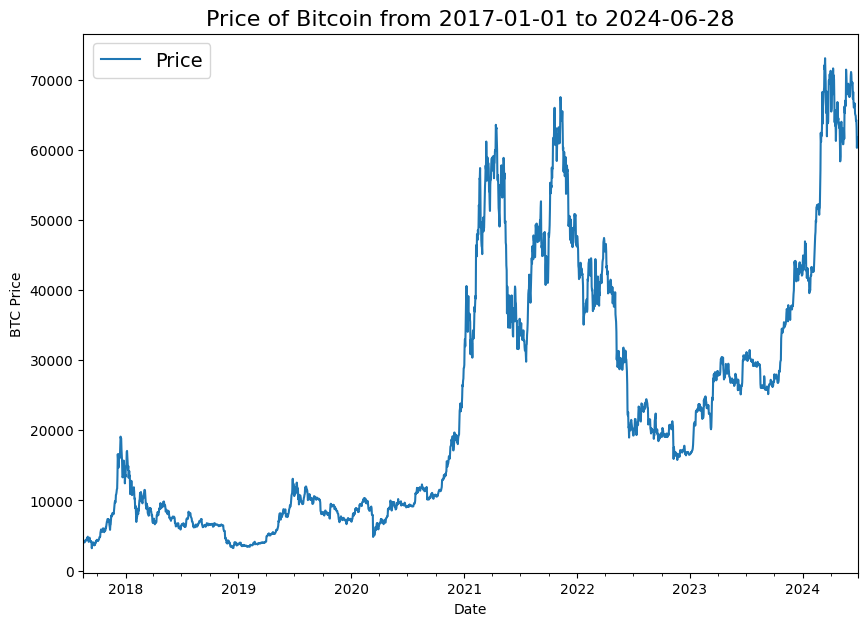

In [9]:
btc_prices.plot(figsize=(10, 7))
plt.ylabel("BTC Price")
plt.title(f"Price of Bitcoin from {start_date} to {end_date}", fontsize=16)
plt.legend(fontsize=14);

# Create train & test sets for time series

In [10]:
# Get bitcoin date array
timesteps = btc_prices.index.to_numpy()
prices = btc_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2017-08-17T00:00:00.000000000', '2017-08-18T00:00:00.000000000',
        '2017-08-19T00:00:00.000000000', '2017-08-20T00:00:00.000000000',
        '2017-08-21T00:00:00.000000000', '2017-08-22T00:00:00.000000000',
        '2017-08-23T00:00:00.000000000', '2017-08-24T00:00:00.000000000',
        '2017-08-25T00:00:00.000000000', '2017-08-26T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([4285.08, 4108.37, 4139.98, 4086.29, 4016.  , 4040.  , 4114.01,
        4316.01, 4280.68, 4337.44]))

In [11]:
split_size = int(0.8 * len(prices)) # 80% train, 20% test

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything after the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2006, 502, 2006, 502)

Let's visualize

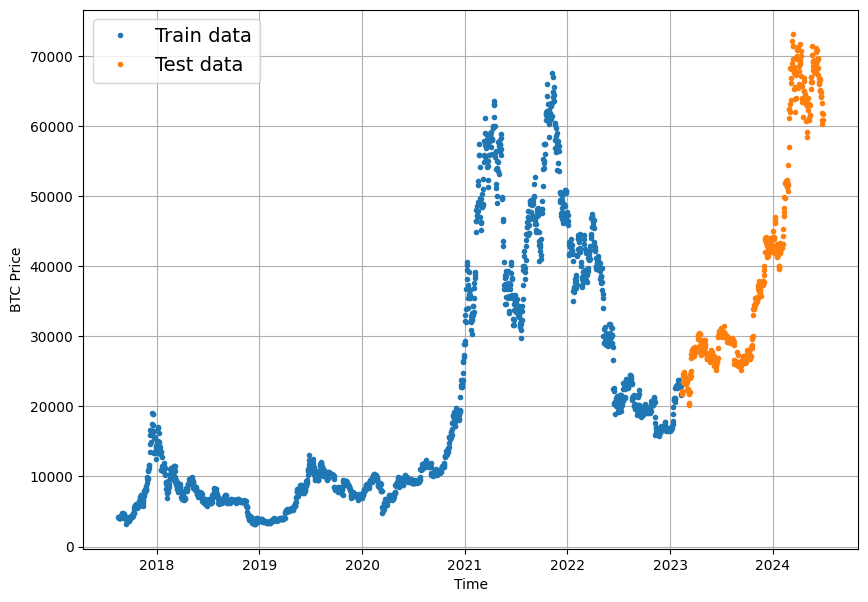

In [12]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

# Modelling Experiments

* **horizon** = number of timesteps to predict into future
* **window** = number of timesteps from past used to predict **horizon**

<table style="width: 100%">
    <tr>
        <th style="text-align: center; vertical-align: middle;">Model Number</th>
        <th style="text-align: center; vertical-align: middle;">Model Type</th>
        <th style="text-align: center; vertical-align: middle;">Horizon size</th>
        <th style="text-align: center; vertical-align: middle;">Window size</th>
        <th style="text-align: center; vertical-align: middle;">Extra data</th>
    </tr>
    <tr>
        <td style="text-align: center; vertical-align: middle;">0</td>
        <td style="text-align: center; vertical-align: middle;">Forecasting with sktime (baseline)</td>
        <td style="text-align: center; vertical-align: middle;">0.5% data ≈ 13</td>
        <td style="text-align: center; vertical-align: middle;">25</td>
        <td style="text-align: center; vertical-align: middle;">NA</td>
    </tr>
    <tr>
        <td style="text-align: center; vertical-align: middle;">1</td>
        <td style="text-align: center; vertical-align: middle;">Dense model</td>
        <td style="text-align: center; vertical-align: middle;">1</td>
        <td style="text-align: center; vertical-align: middle;">7</td>
        <td style="text-align: center; vertical-align: middle;">NA</td>
    </tr>
    <tr>
        <td style="text-align: center; vertical-align: middle;">2</td>
        <td style="text-align: center; vertical-align: middle;">Same as 1</td>
        <td style="text-align: center; vertical-align: middle;">1</td>
        <td style="text-align: center; vertical-align: middle;">30</td>
        <td style="text-align: center; vertical-align: middle;">NA</td>
    </tr>
    <tr>
        <td style="text-align: center; vertical-align: middle;">3</td>
        <td style="text-align: center; vertical-align: middle;">Same as 1</td>
        <td style="text-align: center; vertical-align: middle;">7</td>
        <td style="text-align: center; vertical-align: middle;">30</td>
        <td style="text-align: center; vertical-align: middle;">NA</td>
    </tr>
    <tr>
        <td style="text-align: center; vertical-align: middle;">4</td>
        <td style="text-align: center; vertical-align: middle;">Conv1D</td>
        <td style="text-align: center; vertical-align: middle;">1</td>
        <td style="text-align: center; vertical-align: middle;">7</td>
        <td style="text-align: center; vertical-align: middle;">NA</td>
    </tr>
    <tr>
        <td style="text-align: center; vertical-align: middle;">5</td>
        <td style="text-align: center; vertical-align: middle;">LSTM</td>
        <td style="text-align: center; vertical-align: middle;">1</td>
        <td style="text-align: center; vertical-align: middle;">7</td>
        <td style="text-align: center; vertical-align: middle;">NA</td>
    </tr>
    <tr>
        <td style="text-align: center; vertical-align: middle;">6</td>
        <td style="text-align: center; vertical-align: middle;">Same as 1 (but with multivariate data)</td>
        <td style="text-align: center; vertical-align: middle;">1</td>
        <td style="text-align: center; vertical-align: middle;">7</td>
        <td style="text-align: center; vertical-align: middle;">Block reward size</td>
    </tr>
    <tr>
        <td style="text-align: center; vertical-align: middle;">7</td>
        <td style="text-align: center; vertical-align: middle;"><a href="https://arxiv.org/pdf/1905.10437.pdf">N-BEATs Algorithm</a></td>
        <td style="text-align: center; vertical-align: middle;">1</td>
        <td style="text-align: center; vertical-align: middle;">7</td>
        <td style="text-align: center; vertical-align: middle;">NA</td>
    </tr>
    <tr>
        <td style="text-align: center; vertical-align: middle;">8</td>
        <td style="text-align: center; vertical-align: middle;">Ensemble (multiple models optimized on different loss functions)</td>
        <td style="text-align: center; vertical-align: middle;">1</td>
        <td style="text-align: center; vertical-align: middle;">7</td>
        <td style="text-align: center; vertical-align: middle;">NA</td>
    </tr>
    <tr>
        <td style="text-align: center; vertical-align: middle;">9</td>
        <td style="text-align: center; vertical-align: middle;">Future prediction model (model to predict future values)</td>
        <td style="text-align: center; vertical-align: middle;">1</td>
        <td style="text-align: center; vertical-align: middle;">7</td>
        <td style="text-align: center; vertical-align: middle;">NA</td>
    </tr>
    <tr>
        <td style="text-align: center; vertical-align: middle;">10</td>
        <td style="text-align: center; vertical-align: middle;">Same as 1 (but with turkey 🦃 data introduced)</td>
        <td style="text-align: center; vertical-align: middle;">1</td>
        <td style="text-align: center; vertical-align: middle;">7</td>
        <td style="text-align: center; vertical-align: middle;">NA</td>
    </tr>
</table>

## Model 0: Forecasting with sktime (baseline)

In [13]:
# Concatenate the train and test sets
dates = np.concatenate((X_train, X_test))
prices = np.concatenate((y_train, y_test))

# Create a DataFrame
data = pd.DataFrame({"Date": dates, "Price": prices})

# Ensure the Date column is in datetime format and set it as the index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [14]:
# Split the data into training and test sets
y_train_baseline, y_test_baseline = temporal_train_test_split(data['Price'], test_size=0.005)

In [15]:
# Create the regressor
regressor = KNeighborsRegressor(n_neighbors=3)

# Create the forecasting model using make_reduction
forecaster = make_reduction(regressor, window_length=25, strategy="direct")

In [16]:
fh = [i for i in range(1, len(y_test_baseline) + 1)]

# Fit the model
forecaster.fit(y_train_baseline, fh=fh)

# Make predictions
y_pred_baseline = forecaster.predict(fh)

In [17]:
evaluate_preds(y_true=y_test_baseline, y_pred=y_pred_baseline)

Mean Absolute Error (MAE): 2080.7544
Mean Squared Error (MSE): 5509210.0239
Root Mean Squared Error (RMSE): 2347.1706
R^2 Score: -0.2530


{'MAE': 2080.75435897436,
 'MSE': 5509210.023916239,
 'RMSE': 2347.1706422661814,
 'R2': -0.2530237837794094}

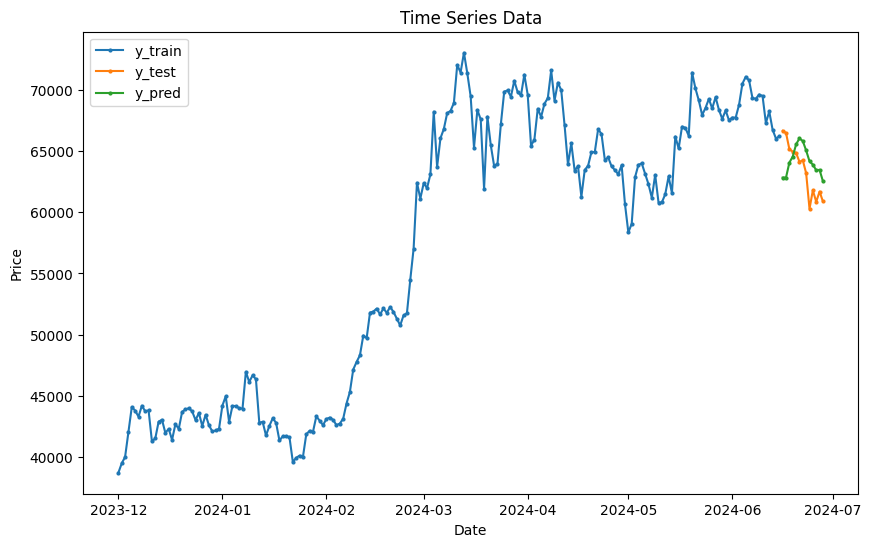

In [18]:
# Plot the predictions
start = pd.to_datetime("2023-12-01")
custom_plot_series(y_train_baseline, y_test_baseline, y_pred_baseline, start=start, marker_size=2)

# Preprocessing data

## Windowing dataset

Example: Window for one week (univariate time series)
```
[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

In [19]:
HORIZON = 1 # predict 1 step at a time
WINDOW_SIZE = 7 # use a week worth of timesteps to predict the horizon

In [20]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8


In [21]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2501, 2501)

In [22]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [4285.08 4108.37 4139.98 4086.29 4016.   4040.   4114.01] -> Label: [4316.01]
Window: [4108.37 4139.98 4086.29 4016.   4040.   4114.01 4316.01] -> Label: [4280.68]
Window: [4139.98 4086.29 4016.   4040.   4114.01 4316.01 4280.68] -> Label: [4337.44]


In [23]:
# View the last 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [64974.37 64869.99 64143.56 64262.01 63210.01 60293.3  61806.01] -> Label: [60864.99]
Window: [64869.99 64143.56 64262.01 63210.01 60293.3  61806.01 60864.99] -> Label: [61706.47]
Window: [64143.56 64262.01 63210.01 60293.3  61806.01 60864.99 61706.47] -> Label: [60893.99]


## Turning windows into training and test sets

In [24]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2000, 501, 2000, 501)

## Make a modelling checkpoint

In [25]:
def create_model_checkpoint(model_name, save_path="../models"):
    """
    Creates a callback to save the model checkpoint.

    Parameters:
    - model_name: str
        Name of the model.
    - save_path: str, optional (default="models")
        Directory to save the model file.

    Returns:
    - tf.keras.callbacks.ModelCheckpoint
        ModelCheckpoint callback object.
    """
    # Ensure model_name ends with .keras
    if not model_name.endswith('.keras'):
        model_name += '.keras'

    # Construct the filepath to save the model
    filepath = os.path.join(save_path, model_name)

    # Return ModelCheckpoint callback
    return tf.keras.callbacks.ModelCheckpoint(filepath=filepath,
                                               verbose=0,
                                               save_best_only=True)

# Model 1: Dense model (window = 7, horizon = 1) 

In [26]:
# Construct the model
model_1 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON, activation="linear")                     
], name="model_1_dense") # give the model a name so we can save it

In [27]:
# Compile
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"])

In [28]:
model_1.fit(x=train_windows, # train windows of 7 timesteps of Bitcoin prices
            y=train_labels, # horizon value of 1 (using the previous 7 timesteps to predict next day)
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)]) # create ModelCheckpoint callback to save best model

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 14963.2793 - mae: 14963.2793 - val_loss: 3447.8843 - val_mae: 3447.8843
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2545.2166 - mae: 2545.2166 - val_loss: 3484.9612 - val_mae: 3484.9612
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1362.9019 - mae: 1362.9019 - val_loss: 1271.0532 - val_mae: 1271.0532
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 984.3303 - mae: 984.3303 - val_loss: 1176.6940 - val_mae: 1176.6940
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 880.8625 - mae: 880.8625 - val_loss: 1113.6818 - val_mae: 1113.6818
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 838.0339 - mae: 838.0339 - val_loss: 1196.7063 - val_mae: 1196.7063
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 890.8276 - mae: 890.8276 - val_loss: 1056.3479 - val_mae: 1056.3479
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 813.8746 - mae: 813.8746 - val_loss: 1130.87

In [29]:
model_1.evaluate(test_windows, test_labels)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step - loss: 548.3049 - mae: 548.3049


[727.4464111328125, 727.4464111328125]

In [30]:
# Load in saved best performing model_1 and evaluate on test data
model_1 = tf.keras.models.load_model("../models/model_1_dense.keras")
model_1.evaluate(test_windows, test_labels)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step - loss: 548.9252 - mae: 548.9252


[727.10986328125, 727.10986328125]

In [31]:
def make_preds(model, input_data):
  """
  Uses model to make predictions on input_data.

  Parameters
  ----------
  model: trained model 
  input_data: windowed input data (same kind of data model was trained on)

  Returns model predictions on input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

In [32]:
# Make predictions using model_1 on the test dataset and view the results
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step


(501,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([21723.455, 22164.799, 23979.955, 23739.486, 24405.521, 24753.037,
        24408.852, 24655.078, 24618.066, 24174.412], dtype=float32)>)

In [33]:
model_1_preds = tf.cast(model_1_preds, tf.float64)

In [34]:
tf.squeeze(test_labels).dtype, model_1_preds.dtype

(tf.float64, tf.float64)

In [35]:
evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_1_preds)

Mean Absolute Error (MAE): 727.1097
Mean Squared Error (MSE): 1350539.8109
Root Mean Squared Error (RMSE): 1162.1273
R^2 Score: 0.9948


{'MAE': 727.1097124500998,
 'MSE': 1350539.81091702,
 'RMSE': 1162.1272782776507,
 'R2': 0.9947833229849975}

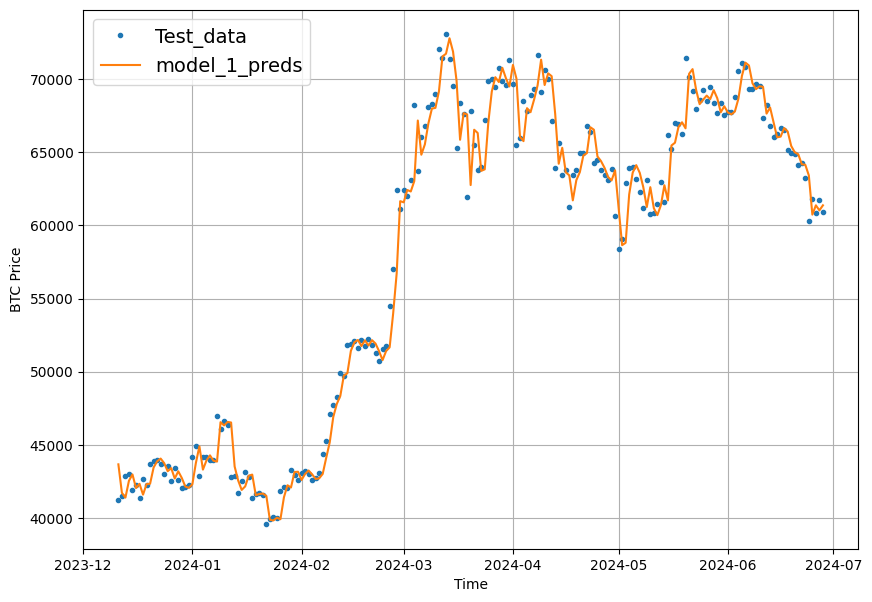

In [41]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format="-", label="model_1_preds")

# Model 2: Dense (window = 30, horizon = 1)

In [43]:
HORIZON = 1 # predict one step at a time
WINDOW_SIZE = 30 # use 30 timesteps in the past

In [44]:
# Make windowed data with appropriate horizon and window sizes
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2478, 2478)

In [45]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(1982, 496, 1982, 496)

In [46]:
model_2 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON) # need to predict horizon number of steps into the future
], name="model_2_dense")

model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

In [47]:
model_2.evaluate(test_windows, test_labels)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - loss: 704.1139


930.81494140625

In [48]:
# Load in saved best performing model_2 and evaluate on test data
model_2 = tf.keras.models.load_model("../models/model_2_dense.keras")
model_2.evaluate(test_windows, test_labels)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step - loss: 569.8344


770.2507934570312

In [49]:
# Get forecast predictions
model_2_preds = make_preds(model_2,
                           input_data=test_windows)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [50]:
evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_2_preds)

Mean Absolute Error (MAE): 770.2508
Mean Squared Error (MSE): 1472566.5004
Root Mean Squared Error (RMSE): 1213.4935
R^2 Score: 0.9943


{'MAE': 770.2507940083165,
 'MSE': 1472566.5004107812,
 'RMSE': 1213.493510658702,
 'R2': 0.994306404849005}

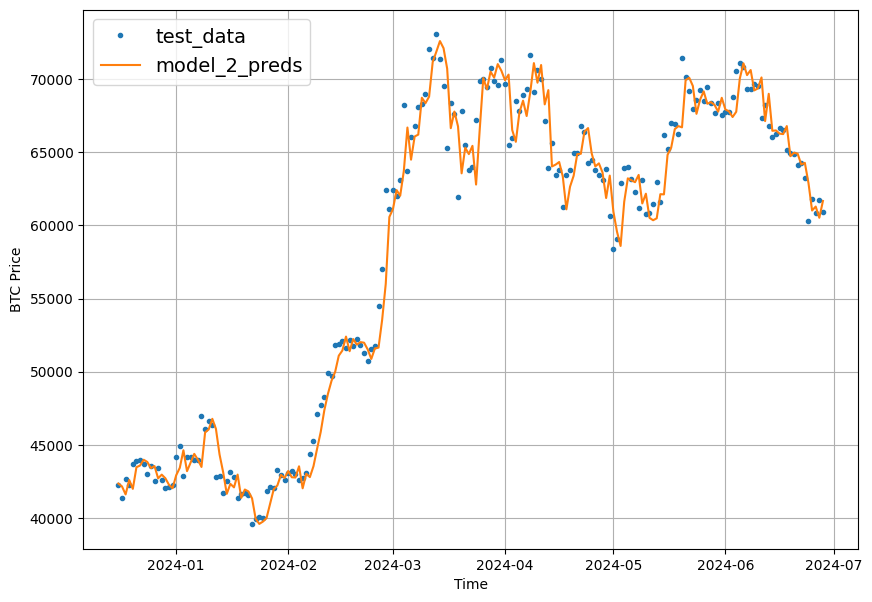

In [53]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, start=offset, format="-", label="model_2_preds") 

# Model 3: Dense (window = 30, horizon = 7)

In [54]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2472, 2472)

In [55]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels, test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(1977, 495, 1977, 495)

In [56]:
model_3 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
], name="model_3_dense")

model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_3.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

In [57]:
model_3.evaluate(test_windows, test_labels)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - loss: 1238.4966


1572.5755615234375

In [58]:
# Load in saved best performing model_3 and evaluate on test data
model_3 = tf.keras.models.load_model("../models/model_3_dense.keras")
model_3.evaluate(test_windows, test_labels)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step - loss: 1194.1522


1509.3931884765625

In [59]:
# Get forecast predictions
model_3_preds = make_preds(model_3,
                           input_data=test_windows)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [60]:
evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_3_preds)

Mean Absolute Error (MAE): 1509.3932
Mean Squared Error (MSE): 5185787.6269
Root Mean Squared Error (RMSE): 2277.2324
R^2 Score: 0.9799


{'MAE': 1509.3931996753242,
 'MSE': 5185787.626938243,
 'RMSE': 2277.2324490350657,
 'R2': 0.9798982386050454}